https://github.com/chainer/chainer/tree/master/examples/vae を元にカスタマイズしたものです。  
(注: GPU利用のみ検証)

In [66]:
from __future__ import print_function

import six
import platform

import numpy as np

import chainer
import chainer.functions as F
from chainer.functions.loss.vae import gaussian_kl_divergence
import chainer.links as L

from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import initializer

import data
from libs import gif

import matplotlib
# Disable interactive backend
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation as ani
%matplotlib inline

import IPython.display as ipyd

def print_version(libs):
    for l in libs:
        print(l.__name__, ":", l.__version__)
    

In [92]:
! lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 16.04.2 LTS
Release:	16.04
Codename:	xenial


In [93]:
! pyenv version

anaconda3-4.4.0 (set by PYENV_VERSION environment variable)


In [67]:
print("python: ", platform.python_version())
print_version([chainer, np, matplotlib, ])

python:  3.6.1
chainer : 2.0.0
numpy : 1.12.1
matplotlib : 2.0.2


In [68]:
# Utility functions
def show_images(x, title):
    fig, ax = plt.subplots(3, 3, figsize=(5, 5), dpi=100)
    fig.suptitle(title, fontsize=8)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28), cmap=plt.cm.gray)
    plt.show()
    
# original images and reconstructed images
def save_images(x, filename):
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    fig.savefig(filename)
    
def graph_export(model):
    with open('graph.dot', 'w') as o:
        g = computational_graph.build_computational_graph((model.loss, ))
        o.write(g.dump())
    print('graph generated')
    
def load_mnist_dataset(test):
    # Prepare dataset
    print('load MNIST dataset')
    mnist = data.load_mnist_data()
    mnist['data'] = mnist['data'].astype(np.float32)
    mnist['data'] /= 255
    mnist['target'] = mnist['target'].astype(np.int32)

    if test:
        mnist['data'] = mnist['data'][0:100]
        mnist['target'] = mnist['target'][0:100]
        N = 30
    else:
        N = 60000

    x_train, x_test = np.split(mnist['data'],   [N])
    y_train, y_test = np.split(mnist['target'], [N])
    N_train = y_train.size
    N_test = y_test.size
    return x_train, x_test, y_train, y_test, N, N_test, N_train


def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m


In [69]:
# Reference: https://jmetzen.github.io/2015-11-27/vae.html
class Xavier(initializer.Initializer):
    """
    Xavier initializaer 
    Reference: 
    * https://jmetzen.github.io/2015-11-27/vae.html
    * https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    """
    def __init__(self, fan_in, fan_out, constant=1, dtype=None):
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.high = constant*np.sqrt(6.0/(fan_in + fan_out))
        self.low = -self.high
        super(Xavier, self).__init__(dtype)

    def __call__(self, array):
        xp = cuda.get_array_module(array)
        args = {'low': self.low, 'high': self.high, 'size': array.shape}
        if xp is not np:
            # Only CuPy supports dtype option
            if self.dtype == np.float32 or self.dtype == np.float16:
                # float16 is not supported in cuRAND
                args['dtype'] = np.float32
        array[...] = xp.random.uniform(**args)


# Original implementation: https://github.com/chainer/chainer/tree/master/examples/vae
class VAE(chainer.Chain):
    """Variational AutoEncoder"""

    def __init__(self, n_in, n_latent, n_h, act_func=F.tanh):
        super(VAE, self).__init__()
        self.act_func = act_func
        with self.init_scope():
            # encoder
            self.le1        = L.Linear(n_in, n_h,      initialW=Xavier(n_in, n_h))
            self.le2        = L.Linear(n_h,  n_h,      initialW=Xavier(n_h, n_h))
            self.le3_mu     = L.Linear(n_h,  n_latent, initialW=Xavier(n_h,  n_latent))
            self.le3_ln_var = L.Linear(n_h,  n_latent, initialW=Xavier(n_h,  n_latent))
            
            # decoder
            self.ld1 = L.Linear(n_latent, n_h, initialW=Xavier(n_latent, n_h))
            self.ld2 = L.Linear(n_h,      n_h, initialW=Xavier(n_h, n_h))
            self.ld3 = L.Linear(n_h,      n_in,initialW=Xavier(n_h, n_in))

    def __call__(self, x, sigmoid=True):
        """ AutoEncoder """
        return self.decode(self.encode(x)[0], sigmoid)

    def encode(self, x):
        x.name = "x"
        h1 = self.act_func(self.le1(x))
        h1.name = "enc_h1"
        h2 = self.act_func(self.le2(h1))
        h2.name = "enc_h2"
        mu = self.le3_mu(h2)
        mu.name = "z_mu"
        ln_var = self.le3_ln_var(h2)  # ln_var = log(sigma**2)
        ln_var.name = "z_ln_var"
        return mu, ln_var

    def decode(self, z, sigmoid=True):
        h1 = self.act_func(self.ld1(z))
        h1.name = "dec_h1"
        h2 = self.act_func(self.ld2(h1))
        h2.name = "dec_h2"
        h3 = self.ld3(h2)
        h3.name = "dec_h3"
        if sigmoid:
            return F.sigmoid(h3)
        else:
            return h3

    def get_loss_func(self, C=1.0, k=1):
        """Get loss function of VAE.

        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.

        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
        """
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu.data)
            # reconstruction loss
            rec_loss = 0
            for l in six.moves.range(k):
                z = F.gaussian(mu, ln_var)
                z.name = "z"
                rec_loss += F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (k * batchsize)
            self.rec_loss = rec_loss
            self.rec_loss.name = "reconstruction error"
            self.latent_loss = C * gaussian_kl_divergence(mu, ln_var) / batchsize
            self.latent_loss.name = "latent loss"
            self.loss = self.rec_loss + self.latent_loss
            self.loss.name = "loss"
            return self.loss
        return lf

In [94]:
# settings
initmodel = ''
resume = ''
gpu = 0
n_epoch = 100
n_latent = 20
# n_latent = 2
batchsize = 100

test = False
graph_gen = False

In [95]:
# Prepare dataset
x_train, x_test, y_train, y_test, N, N_test, N_train = load_mnist_dataset(test)

load MNIST dataset


In [96]:
# Prepare VAE model
model = VAE(784, n_latent, n_h=500, act_func=F.softplus)

if gpu >= 0:
    cuda.get_device_from_id(gpu).use()
    model.to_gpu()
xp = np if gpu < 0 else cuda.cupy


In [97]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

# Init/Resume
if initmodel:
    print('Load model from', initmodel)
    serializers.load_npz(initmodel, model)
if resume:
    print('Load optimizer state from', resume)
    serializers.load_npz(resume, optimizer)


In [98]:
# Learning loop
loss_list_train = []
loss_list_test = []

for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)

    # training
    perm = np.random.permutation(N)
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        optimizer.update(model.get_loss_func(), x)
        if epoch == 1 and i == 0 and graph_gen:
            graph_export(model)

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
    loss_train = sum_loss / N
    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / N, sum_rec_loss / N))

    # evaluation
    sum_loss = 0
    sum_rec_loss = 0
    with chainer.no_backprop_mode():
        for i in six.moves.range(0, N_test, batchsize):
            x = chainer.Variable(xp.asarray(x_test[i:i + batchsize]))
            loss_func = model.get_loss_func(k=10)
            loss_func(x)
            sum_loss += float(model.loss.data) * len(x.data)
            sum_rec_loss += float(model.rec_loss.data) * len(x.data)
            del model.loss
    print('test  mean loss={}, mean reconstruction loss={}'
          .format(sum_loss / N_test, sum_rec_loss / N_test))

epoch 1
train mean loss=173.56411231994628, mean reconstruction loss=165.10864996592204
test  mean loss=137.0318674468994, mean reconstruction loss=123.36666328430175
epoch 2
train mean loss=128.2658342107137, mean reconstruction loss=113.50581760406494
test  mean loss=120.77212059020997, mean reconstruction loss=104.8487646484375
epoch 3
train mean loss=117.45149834950765, mean reconstruction loss=101.20490942637126
test  mean loss=113.1260725402832, mean reconstruction loss=96.25947601318359
epoch 4
train mean loss=112.50161712646485, mean reconstruction loss=95.14562651316325
test  mean loss=109.89147743225098, mean reconstruction loss=91.89801429748535
epoch 5
train mean loss=109.61022795359294, mean reconstruction loss=91.49670948028565
test  mean loss=108.27069747924804, mean reconstruction loss=89.63211608886719
epoch 6
train mean loss=107.64166365305583, mean reconstruction loss=89.12714210510254
test  mean loss=106.40213401794433, mean reconstruction loss=87.59944038391113
epo

In [99]:
# Save the model and the optimizer
print('save the model')
serializers.save_npz('mlp.model', model)
print('save the optimizer')
serializers.save_npz('mlp.state', optimizer)

# model.to_cpu()

save the model
save the optimizer


In [100]:
x_sample = chainer.Variable(x_test[:10].astype(np.float32))
x_sample.to_gpu()

In [101]:
type(x_sample)

chainer.variable.Variable

### 復元前と後の画像の比較

In [102]:

def convert(data_gpu):
    data_gpu = data_gpu*255
    data_gpu = data_gpu.data.astype(xp.int32)
    return chainer.cuda.to_cpu(data_gpu)

def draw_result(model, x, n=10):
    assert n > 0
    x_sample = x[:n]
    x_sample = chainer.Variable(x_sample.astype(np.float32))
    x_sample.to_gpu()
    x_reconstruct = model(x_sample)
    

    x_sample = convert(x_sample)
    x_reconstruct = convert(x_reconstruct)
    
    plt.figure(figsize=(8, n*3))
    for i in range(n):
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=255, cmap="gray")
        plt.title("Input image")
        plt.xticks([]);plt.yticks([])
        
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=255, cmap="gray")
        plt.title("Reconstruction image")
        plt.xticks([]);plt.yticks([])
    plt.tight_layout()


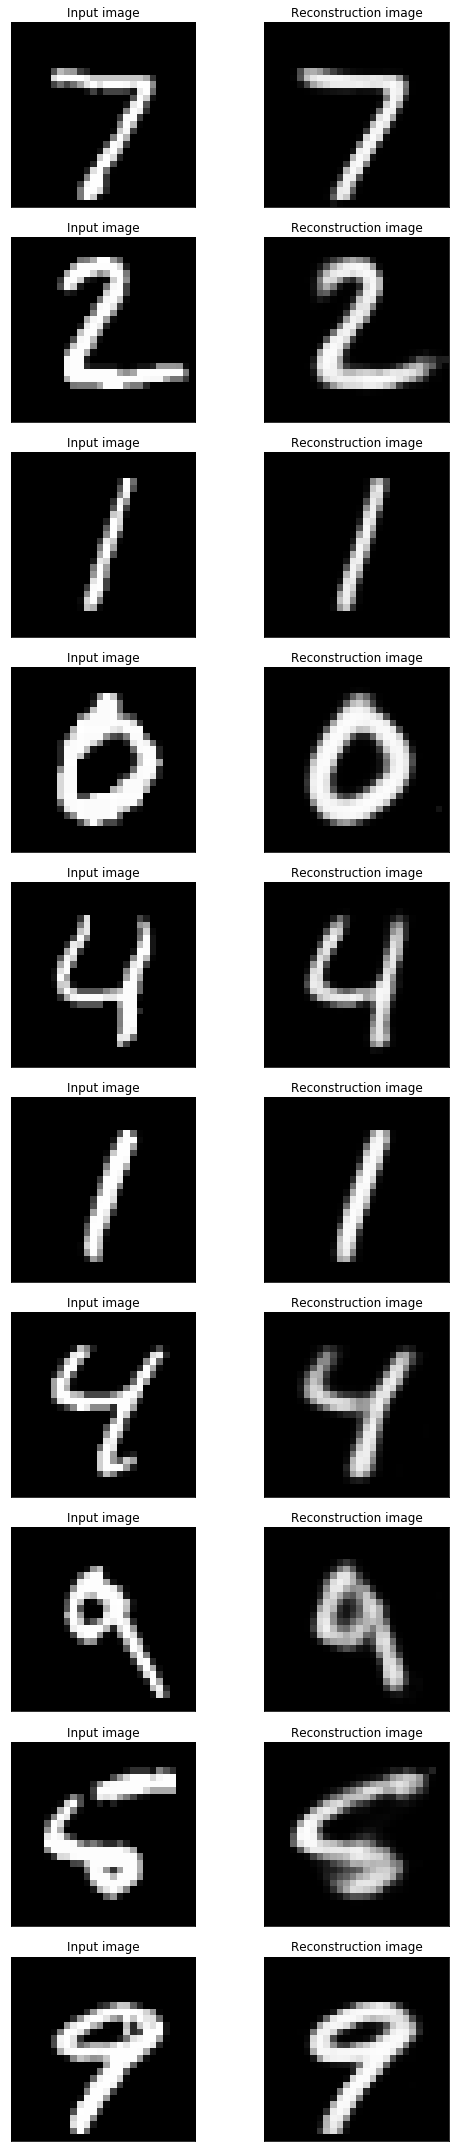

In [103]:
# OriginalとReconstrauctionの比較
draw_result(model, x_test)

### 0〜9までのzを取り出してを表示する

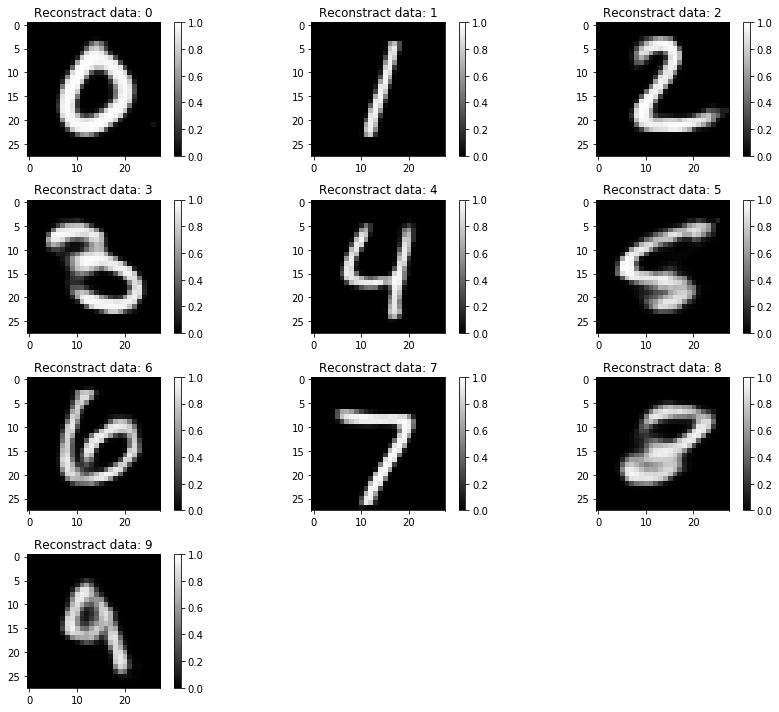

In [104]:
n_sample = 100
x_sample, y_sample = x_test[:n_sample], y_test[:n_sample]

idx_list = []
for i in range(10):
    idx = y_sample==i
    #np.arange(len(idx))
    idx_list.append(np.min(np.arange(n_sample)[idx]))

x_sample, y_sample = x_test[idx_list], y_test[idx_list]
z_mu = model.encode(chainer.cuda.to_gpu(x_sample))[0]
x_reconstract = model.decode(z_mu)
#x_reconstract = model(chainer.cuda.to_gpu(x_sample))
x_reconstract.to_cpu()

plt.figure(figsize=(12,10))
for i, x_gen in enumerate(x_reconstract.data):
    plt.subplot(4,3,i+1)
    plt.imshow(x_gen.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstract data: {}".format(i))
    plt.colorbar()
plt.tight_layout()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 

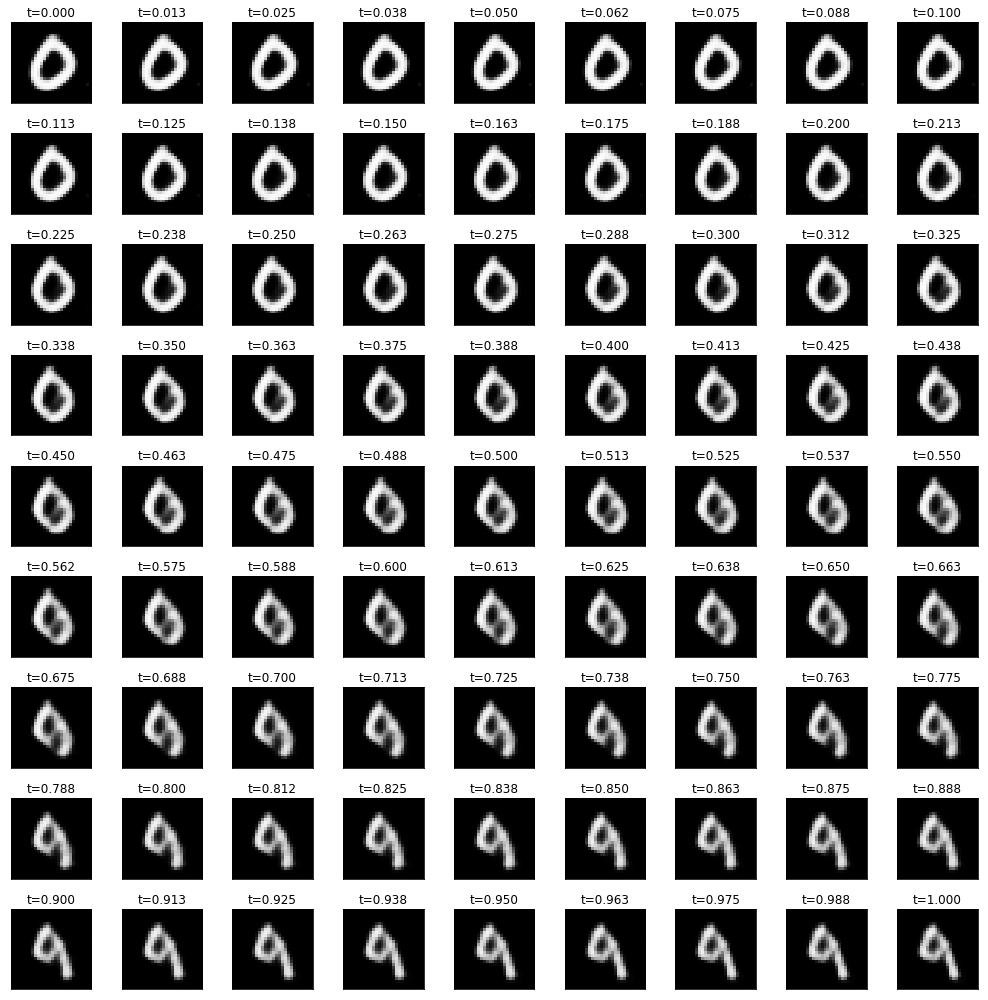

In [106]:
start = 0
end   = 9
n_image = 81
n_row = int(np.ceil(np.sqrt(n_image)))
imgs = []

plt.figure(figsize=(14,14))
for i, t in enumerate(np.linspace(0, 1, n_image)):
    print(i, end=", ")
    z_tmp = (1-t)*z_mu[start] + t*z_mu[end]
    x_gen = model.decode(z_tmp.reshape(1, n_latent))
    
    plt.subplot(n_row, n_row, i+1)
    im = convert(x_gen).reshape(28, 28)
    plt.imshow(im, vmin=0, vmax=255, cmap="gray")
    imgs.append(im)
    plt.xticks([]);plt.yticks([])
    plt.title("t={0:.3f}".format(t))
plt.tight_layout()


##### ImageMagikのインストール
アニメーション作成に必要です
```
sudo apt-get install imagemagick
sudo apt-get install python-pythonmagick
```

 nframe=0, n_image=400

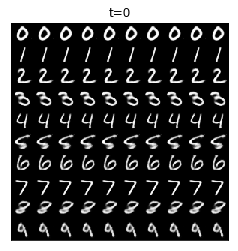

In [114]:
def animate(nframe):
    print("\r nframe={}, n_image={}".format(nframe, n_image), end="")
    plt.imshow(imgs[nframe], cmap="gray")
    plt.xticks([]);plt.yticks([])
    plt.title("t={}".format(nframe))

fig = plt.figure(figsize=(4,4))
anim = ani.FuncAnimation(fig, animate, frames=n_image)
anim.save('vae_{}to{}.gif'.format(start, end), writer='imagemagick', fps=12, dpi=64)

#anim.save('vae_{}to{}.mp4'.format(start, end))

In [108]:
ipyd.Image(url='vae_{}to{}.gif?i={}'.format(start, end, np.random.rand()), height=300, width=300)

### 全ての数字を対象にアニメーション作成

In [109]:
type(z_tmp)

chainer.variable.Variable

In [116]:
n_image = 40
imgs = []
for i, t in enumerate(np.r_[np.linspace(0, 1, n_image), np.linspace(0, 1, n_image)[::-1]]):
    tmp_imgs = []
    print("\r i={}, n_image={}".format(i, n_image), end="")
    for start in range(10):
        for end in range(10):
            n_row = int(np.ceil(np.sqrt(n_image)))

            z_tmp = (1-t)*z_mu[start] + t*z_mu[end]
            x_gen = model.decode(z_tmp.reshape(1, n_latent))
            tmp_imgs.append(convert(x_gen).reshape(28, 28))
    imgs.append(montage(tmp_imgs))

def animate(nframe):
    print(nframe, end=', ')
    plt.imshow(imgs[nframe], cmap="gray")
    plt.xticks([]);plt.yticks([])
    plt.title("t={}".format(nframe))

fig = plt.figure(figsize=(6,6))
anim = ani.FuncAnimation(fig, animate, frames=n_image*2)
anim.save('vae_all_{}to{}.gif'.format(start, end), writer='imagemagick', fps=10, dpi=64)
plt.close()            

 i=79, n_image=400, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 

In [117]:
ipyd.Image(url='vae_all_{}to{}.gif?i={}'.format(start, end, np.random.rand()), height=400, width=400)


### 2次元にプロットする

以下のコードは`n_latent=2`で学習したのち実行してください。

In [89]:
def get_mean(z_mu, y_sample, num):
    for i in range(10):
        idx = y_sample==num
        return np.mean(z_mu[idx], axis=0)

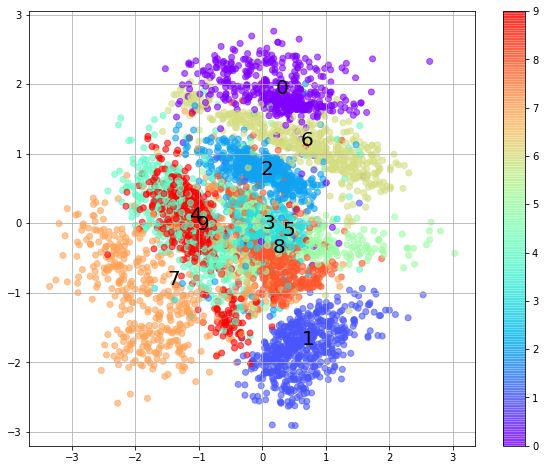

In [90]:
n_sample = 5000
x_sample, y_sample = x_test[:n_sample], y_test[:n_sample]

z_mu = model.encode(chainer.cuda.to_gpu(x_sample))[0]
z_mu.to_cpu()
z_mu = z_mu.data

plt.figure(figsize=(10, 8)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample, cmap="rainbow", alpha=0.6)
for i in range(10):
    m = get_mean(z_mu, y_sample, i)
    plt.text(m[0], m[1], "{}".format(i), fontsize=20)

plt.colorbar()
plt.grid()

 cnt=624/625

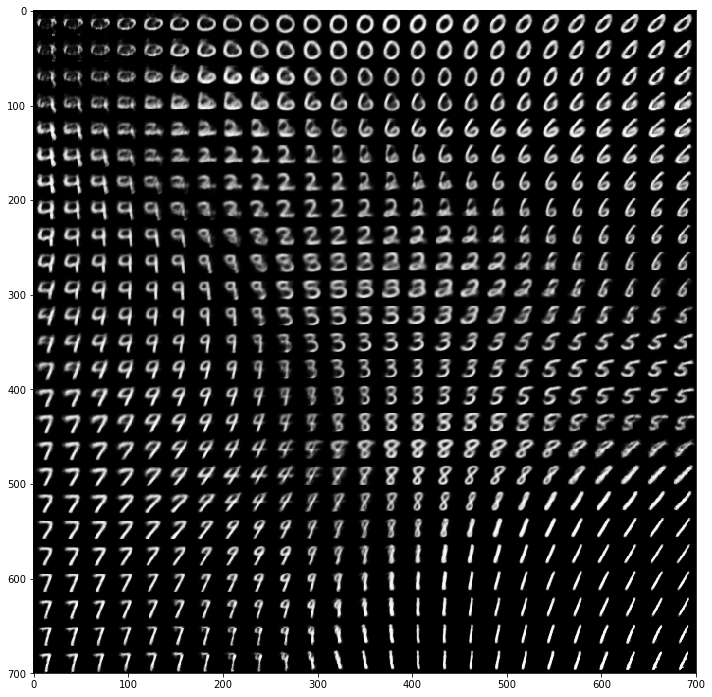

In [76]:
# z to Xの可視化

nx = ny = 25
x_values = xp.linspace(-2, 2, nx)
y_values = xp.linspace(-2, 2, ny)

cnt = 0
canvas = xp.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        print("\r cnt={}/{}".format(cnt, nx*ny), end=""); cnt += 1
        # draw images from randomly sampled z
        z = chainer.Variable(xp.array([[xi, yi]], dtype=xp.float32)) 
        x_mean = model.decode(z)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = (x_mean*255).data.astype(xp.int32).reshape(28,28)
        
# GPUのデータをCPUに移す
canvas_cpu = chainer.cuda.to_cpu(canvas)

plt.figure(figsize=(10, 15))        
Xi, Yi = xp.meshgrid(x_values, y_values)
plt.imshow(canvas_cpu, origin="upper", cmap="gray")
plt.tight_layout()

### グラフ構造の可視化

In [ ]:
# graphviz is necessary.
!dot -Tpng graph.dot -o vae_graph.png

<img src="vae_graph.png?a=1">